In [109]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join as pjoin
from tqdm import tqdm

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from utils import *

# Hyperparameters

## EDA

## ML

# Get the data

In [3]:
data_folder = pjoin("data", "MixedShapesRegularTrain")
train_fname = "MixedShapesRegularTrain_TRAIN.tsv"
test_fname = "MixedShapesRegularTrain_TEST.tsv"

train_data = pd.read_csv(pjoin(data_folder, train_fname), sep='\t')

# EDA

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Columns: 1025 entries, 1 to 1.1120469
dtypes: float64(1024), int64(1)
memory usage: 3.9 MB


In [5]:
train_data.head()

,1,1.1309687,1.1204832,1.1077719,1.0424568,0.96409116,0.91385703,0.9255513,0.90369937,0.91716544,...,0.67574464,0.66714198,0.75205753,0.82026784,0.8957213,0.9829251,1.0491094,1.0931087,1.1025334,1.1120469
0,1,0.830904,0.815222,0.803198,0.742477,0.683805,0.672666,0.673233,0.679851,0.664352,...,0.545351,0.540754,0.603622,0.650685,0.708652,0.771576,0.791044,0.816584,0.819874,0.823568
1,1,0.816833,0.810941,0.772436,0.734036,0.695747,0.657560,0.617705,0.579676,0.541709,...,0.677791,0.709058,0.710436,0.729174,0.743558,0.785415,0.802844,0.805283,0.807960,0.810870
2,1,1.942775,1.928545,1.903324,1.879062,1.812798,1.746591,1.675465,1.611625,1.548000,...,1.660595,1.701224,1.748952,1.794030,1.845204,1.864267,1.860472,1.909628,1.958690,1.944351
3,1,1.873812,1.863549,1.814253,1.779266,1.766919,1.735888,1.675732,1.699785,1.720428,...,1.818965,1.854731,1.890964,1.918501,1.903307,1.910518,1.895921,1.881597,1.873381,1.898326
4,1,2.314335,2.302548,2.283370,2.246295,2.189444,2.150547,2.092030,2.038564,2.015111,...,1.970946,2.020198,2.072746,2.123032,2.172533,2.219684,2.267653,2.315809,2.317153,2.329100


In [6]:
#TODO: should I sort the column names?

**Conclusion: the features and the labels can be seperated by the column dtype**

In [7]:
# splitting the dataset to its features and labels
features = train_data.select_dtypes(include=['float64'])
labels = train_data.select_dtypes(include=['int64'])


In [8]:
# get the labels column name
print(labels.columns)

Index(['1'], dtype='object')


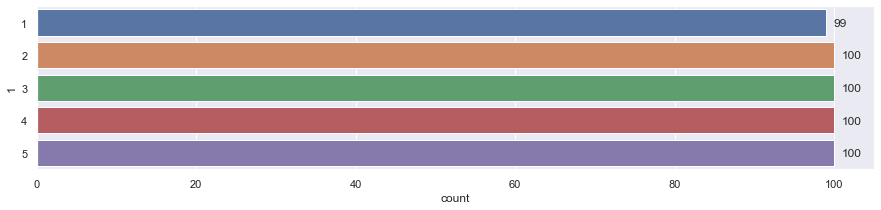

In [9]:
# get labels stats
plt.figure(figsize=(15,3))
ax = sns.countplot(y="1", data=labels)

for p in ax.patches:
    ax.annotate(f'{p.get_width()}', (p.get_width()+1, p.get_y()+0.5))

**Conclusion: balanced dataset**

## Visualuziation

In [10]:
NUM_SAMPLES_PER_CLASS = 10

grouped_by_class = train_data.groupby("1")
samples = grouped_by_class.apply(lambda x: x.sample(NUM_SAMPLES_PER_CLASS))
samples = samples.drop(["1"], axis=1) #the op keeps the groupby col for some reason

class_names = samples.index.get_level_values(0).unique()

samples.shape

(50, 1024)

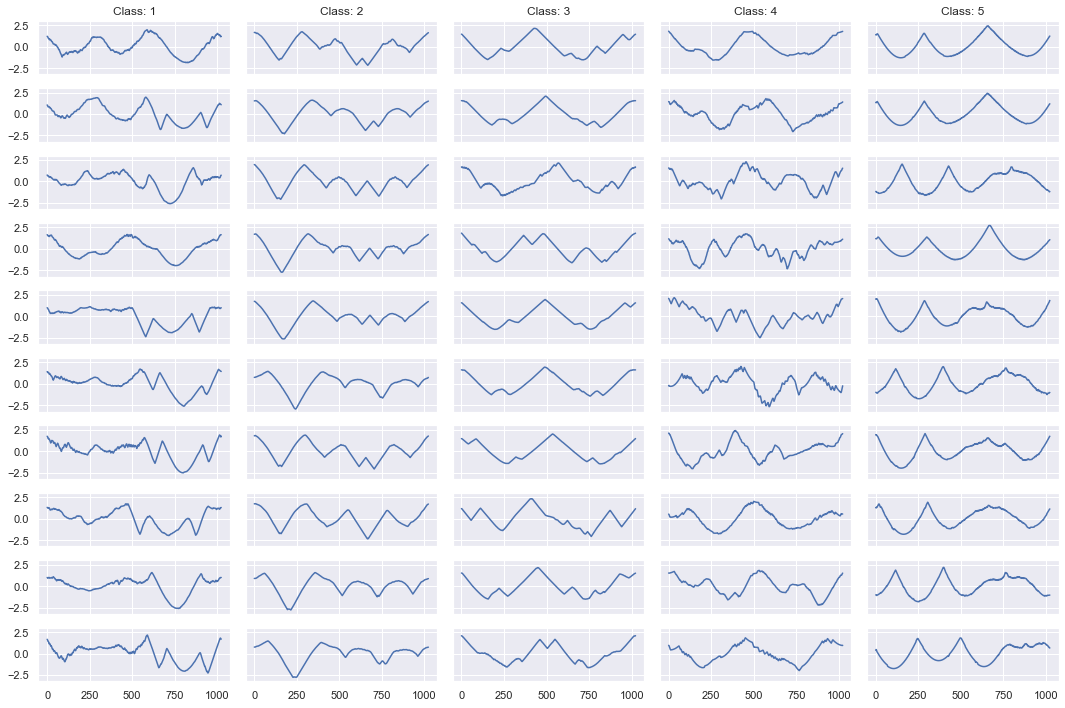

In [11]:
fig, axes = plt.subplots(NUM_SAMPLES_PER_CLASS, len(class_names), figsize=(15,10), sharex=True, sharey=True)

for j, cls in enumerate(class_names):
    for i in range(NUM_SAMPLES_PER_CLASS):
        row = samples.loc[cls].iloc[i]
        sns.lineplot(x=range(len(row.index)), y=row.values, ax=axes[i][j])
        if i==0:
            axes[i][j].set_title(f"Class: {cls}")
    

plt.tight_layout()

**Conclusion: looks like a clustering \ knn algorythm will be usefull. I've noticed that some classes (e.g. 1) might have multiple sub-clusters**
**Conclusion: looks like a low pass filtering would be usefull**

## Data Cleaning

In [12]:
# any dupplicates
features.duplicated().any()

False

**Conclusion: No**

In [13]:
# any missing values
features.isna().sum().sum()

0

**Conclusion: No**

## Remove outliers

# Data splitting

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
#TODO: do a kfold cross validation split


In [16]:
# splitting to train, val, test
X_train, X_test, y_train, y_test = train_test_split(features, labels, stratify=labels, test_size=0.1)#, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.22)#, random_state=1)

print("Train: ", np.unique(y_train, return_counts = True))
print("Val: ", np.unique(y_val, return_counts = True))
print("Test: ", np.unique(y_test, return_counts = True))

Train:  (array([1, 2, 3, 4, 5], dtype=int64), array([70, 70, 70, 70, 70], dtype=int64))
Val:  (array([1, 2, 3, 4, 5], dtype=int64), array([19, 20, 20, 20, 20], dtype=int64))
Test:  (array([1, 2, 3, 4, 5], dtype=int64), array([10, 10, 10, 10, 10], dtype=int64))


# Preprocessing

**Conclusion: all sequences have the same length, therefore there is no need for special care in this aspect**

In [17]:
# resampling

In [18]:
# Low pass filtering

# Feature extraction

# Clustering

In [20]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [21]:
Z=linkage(features, "ward")

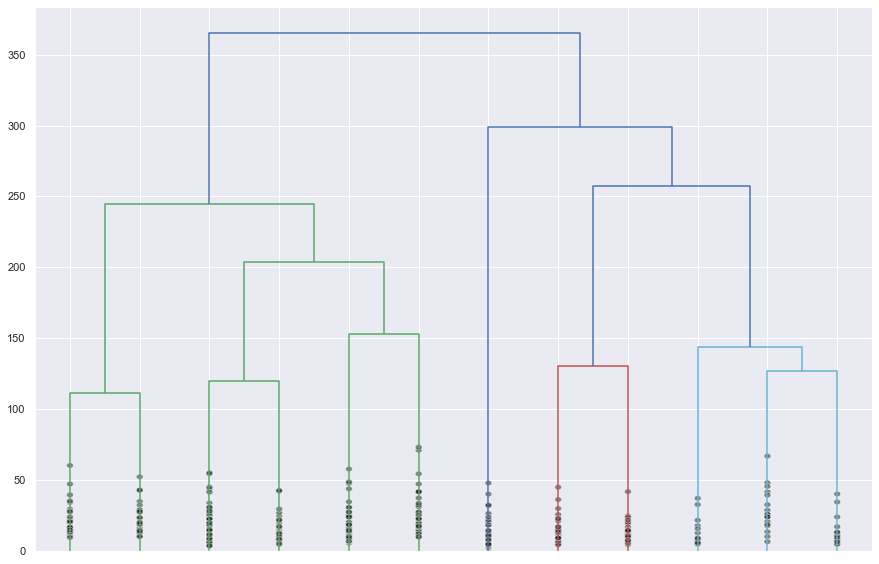

In [26]:
plt.figure(figsize=(15,10))
dendrogram(
    Z,
    truncate_mode="lastp",
    p=12,
    show_leaf_counts=False,
    leaf_rotation=90.,
    leaf_font_size=8.,
    show_contracted=True,
)
plt.show()

In [28]:
from tslearn.clustering import TimeSeriesKMeans

d:\raz\projects\owlytics\venv\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [56]:
tskm = TimeSeriesKMeans(n_clusters=5, metric="euclidean", max_iter=5, random_state=0)

In [57]:
clusters = tskm.fit(X_train)

In [58]:
clusters.labels_

array([2, 4, 4, 1, 2, 3, 2, 2, 0, 4, 4, 2, 0, 3, 2, 1, 2, 2, 0, 3, 4, 2,
       0, 2, 0, 2, 4, 2, 4, 2, 2, 0, 2, 4, 2, 0, 0, 0, 1, 4, 4, 3, 3, 4,
       0, 3, 2, 4, 2, 4, 0, 4, 2, 3, 4, 0, 1, 0, 2, 2, 2, 3, 1, 2, 2, 1,
       1, 1, 2, 2, 2, 2, 0, 4, 2, 2, 2, 2, 4, 4, 4, 2, 2, 2, 1, 0, 4, 4,
       0, 2, 3, 2, 2, 3, 4, 3, 0, 2, 0, 0, 2, 4, 4, 3, 1, 4, 2, 3, 2, 0,
       4, 3, 3, 3, 2, 0, 3, 4, 2, 0, 4, 0, 1, 2, 2, 0, 4, 4, 1, 2, 4, 2,
       4, 2, 1, 2, 0, 0, 2, 2, 2, 2, 2, 2, 1, 0, 4, 3, 4, 4, 3, 0, 1, 3,
       2, 2, 2, 2, 4, 2, 4, 2, 3, 1, 4, 4, 4, 3, 2, 2, 2, 2, 0, 2, 3, 3,
       3, 2, 0, 0, 2, 3, 2, 2, 2, 2, 4, 2, 3, 0, 2, 4, 3, 2, 4, 2, 0, 3,
       0, 2, 1, 4, 3, 2, 2, 0, 2, 2, 4, 3, 3, 2, 2, 2, 1, 3, 2, 4, 3, 3,
       3, 3, 4, 3, 1, 2, 2, 0, 0, 3, 0, 2, 0, 3, 0, 3, 2, 0, 2, 3, 2, 2,
       4, 3, 2, 2, 3, 0, 4, 2, 3, 1, 2, 4, 0, 2, 4, 2, 3, 4, 4, 4, 4, 2,
       3, 2, 0, 2, 3, 1, 3, 1, 2, 4, 2, 0, 4, 4, 4, 2, 2, 3, 2, 4, 0, 3,
       0, 0, 2, 2, 1, 4, 2, 0, 3, 2, 2, 2, 1, 0, 4,

In [59]:
y_train["1"].values

array([4, 4, 3, 5, 1, 3, 3, 3, 4, 2, 2, 3, 5, 1, 3, 5, 3, 3, 5, 1, 2, 3,
       3, 3, 5, 4, 2, 1, 2, 4, 3, 5, 4, 2, 4, 5, 4, 5, 4, 2, 2, 1, 1, 2,
       5, 1, 1, 2, 3, 2, 5, 2, 3, 1, 2, 5, 5, 5, 3, 3, 3, 1, 5, 1, 3, 5,
       4, 5, 4, 3, 4, 3, 5, 2, 2, 3, 3, 4, 2, 4, 2, 4, 2, 4, 5, 3, 2, 2,
       5, 4, 1, 4, 4, 1, 1, 1, 5, 3, 5, 5, 3, 2, 1, 3, 5, 5, 3, 1, 4, 5,
       2, 1, 1, 1, 3, 1, 1, 2, 4, 5, 2, 5, 4, 3, 4, 3, 2, 2, 4, 3, 2, 4,
       2, 3, 5, 3, 5, 5, 4, 3, 3, 4, 3, 3, 5, 5, 2, 1, 2, 2, 1, 5, 5, 1,
       4, 3, 4, 4, 2, 3, 2, 4, 1, 5, 2, 2, 2, 1, 1, 4, 1, 3, 5, 3, 3, 1,
       1, 4, 2, 5, 3, 3, 1, 3, 4, 3, 1, 3, 1, 5, 1, 2, 4, 3, 2, 3, 5, 1,
       5, 3, 4, 2, 1, 3, 4, 5, 4, 3, 4, 1, 1, 3, 4, 1, 5, 1, 1, 2, 1, 1,
       1, 1, 2, 1, 5, 1, 4, 5, 5, 1, 5, 1, 2, 1, 5, 1, 4, 5, 4, 1, 3, 4,
       2, 1, 1, 4, 4, 5, 2, 4, 4, 5, 4, 5, 5, 4, 4, 4, 1, 3, 4, 2, 2, 3,
       1, 3, 5, 3, 1, 4, 1, 5, 3, 2, 4, 5, 2, 2, 2, 4, 3, 1, 2, 2, 5, 1,
       5, 5, 3, 1, 5, 4, 4, 5, 1, 3, 3, 2, 3, 4, 2,

# Modeling

## KNN with DTW

In [71]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

In [75]:
cls1 = X_train.loc[y_train["1"]==1]
cls2 = X_train.loc[y_train["1"]==2]

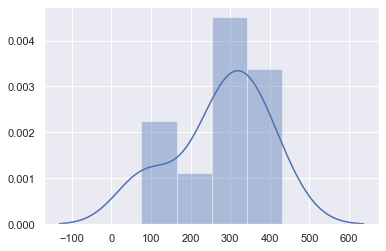

In [91]:
dists = []
for i in range(len(cls1)-65):
    for j in range(i+1, len(cls1)-65):
        x = cls1.iloc[i]
        y = cls1.iloc[j]
        dists.append(fastdtw(x, y, dist=euclidean)[0])
sns.distplot(dists)

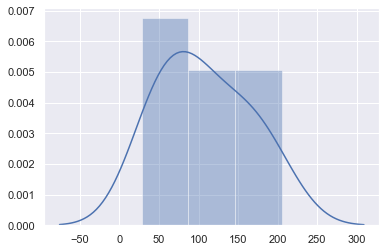

In [92]:
dists2 = []
for i in range(len(cls2)-65):
    for j in range(i+1, len(cls1)-65):
        x = cls2.iloc[i]
        y = cls2.iloc[j]
        dists2.append(fastdtw(x, y, dist=euclidean)[0])
sns.distplot(dists2)

In [96]:
from dtaidistance import dtw

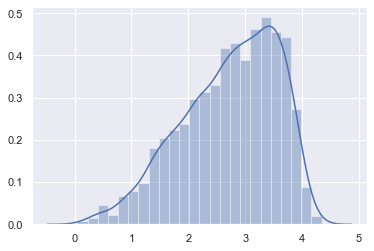

In [107]:
dists = []
for i in range(len(cls1)):
    for j in range(i+1, len(cls1)):
        s1 = cls1.iloc[i].values
        s2 = cls1.iloc[j].values
        dists.append(dtw.distance_fast(s1, s2))
sns.distplot(dists)

In [122]:
dists3 = np.zeros((len(cls1),len(cls1)))
for i in tqdm(range(len(cls2))):
    for j in range(len(cls2)):
        s1 = cls2.iloc[i].values
        s2 = cls2.iloc[j].values
        dists3[i,j] = dtw.distance_fast(s1, s2)
# sns.distplot(dists3)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:23<00:00,  3.00it/s]


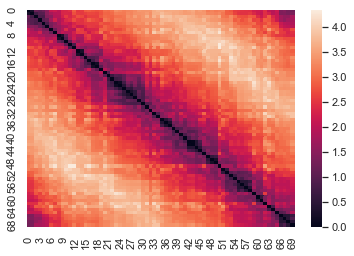

In [121]:
sns.heatmap(dists3)

In [123]:
from sklearn.neighbors import DistanceMetric

In [160]:
dist = DistanceMetric.get_metric(dtw.distance_fast)

In [158]:
s1 = cls2.iloc[0].values
s2 = cls2.iloc[1].values
dtw.distance_fast(s1, s2)

0.05545668393665475

In [161]:
dist.pairwise(np.expand_dims(s1,0),np.expand_dims(s2,0))

array([[7.99975942]])

In [162]:
from sklearn.neighbors import NearestNeighbors

In [164]:
nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree', metric=dtw.distance_fast)

In [165]:
nbrs.fit(X_train)

NearestNeighbors(algorithm='ball_tree', leaf_size=30,
                 metric=<function distance_fast at 0x000001D9E7C07C18>,
                 metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                 radius=1.0)